# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Question to be answered in this analysis
How does a customer respond when they are presented with an offer?

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

# Imports

In [4]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib notebook

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

# 1. Data Inspection & Understanding

In [5]:
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

## 1.1 Portfolio Dataset
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [6]:
portfolio.head(10) #checking the portfolio dataset

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [8]:
portfolio['offer_type'].value_counts() #checking the various offer types and counts

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [9]:
portfolio.isnull().sum() #checking for null values

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [10]:
portfolio.dtypes #checking the dataframe's data types

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

### Key points from the above analysis
1. 10 rows and 6 columns.
2. There are total 3 types of offers. 
3. id column is actually the offer id.
4. Duration is actually the days.
5. Difficulty is in Dollars.

## 1.2 Profile Dataset
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [11]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [12]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [13]:
profile.isnull().sum() #checking for null values

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [14]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [15]:
profile['age'].value_counts().sort_values(ascending=False) #checking the various age

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

How can be someone of age 118 or above 100? There is something wrong. Lets plot the age

In [16]:
profile.dtypes #checking the data types

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

<IPython.core.display.Javascript object>


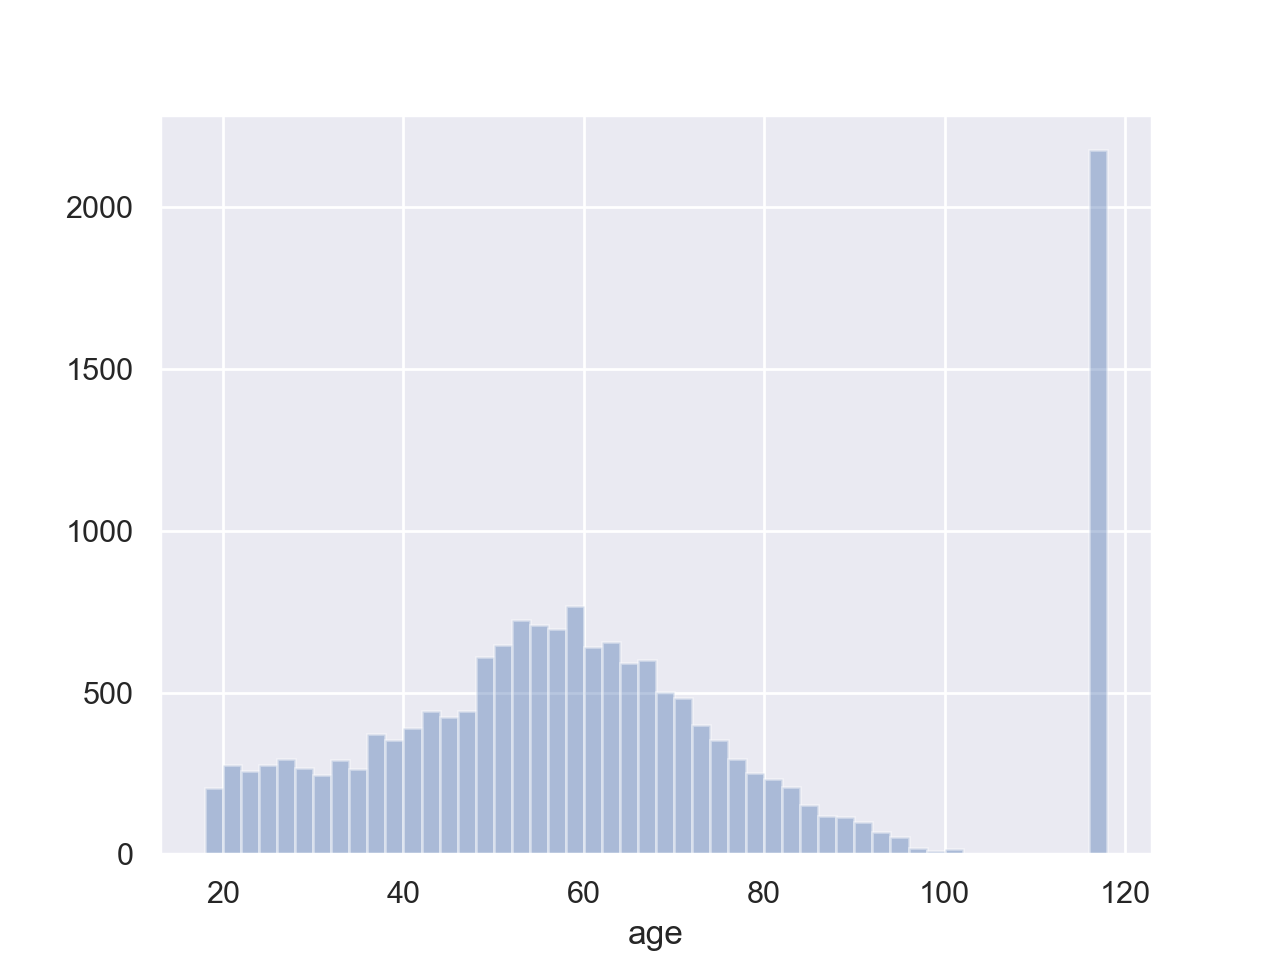

In [17]:
#plotting the age in order to get a clear idea
plt.figure()
sns.distplot(profile['age'], bins=50, kde=False);

From the above graph we can see that there are some ages at 118 and a few above 100.

In [18]:
#cheking if age is 118 then are the various other factors null too?
print(profile[profile['age']==118].count())
profile[['gender','income','age']][profile['age']==118].head() 

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64


,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


The above analysis clears that people with age 118 are mostly either fake entries or people who did not wanted to disclose that information. If need be, we can drop them during the preprocessing of the dataset.

In [19]:
profile['gender'].value_counts() #checking the gender over here. We find 3 M, F & O

M    8484
F    6129
O     212
Name: gender, dtype: int64

### Key points from the above analysis
1. There are 17k rows with 5 columns.
2. id here is customer id.
3. No duplicate rows.
4. The missing values in 'gender' and ‘income’ variables which are are related solely and specifically with the 2175 customers registered at age 118. In other words, customers at age 118 has no registered ‘gender’ and ‘income’. This needs to be taken care of.
5. became member on is a object needs to converted to datetime.

## 1.3 Transcript Dataset
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [20]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [21]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [22]:
transcript.isnull().sum() #checking for null values

person    0
event     0
value     0
time      0
dtype: int64

In [23]:
transcript['event'].value_counts() #checking the various events & their count

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [24]:
transcript.dtypes

person    object
event     object
value     object
time       int64
dtype: object

### Key points from the above analysis.
1. 306534 rows with 4 columns.
2. No missing values.
3. person is customer id

# 2. Data Preparation

## 2.1 Profile dataset

In [25]:
portfolio['channels'].nunique

<bound method IndexOpsMixin.nunique of 0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object>

In [26]:
def clean_portfolio(portfolio):
    '''
    Cleaning the portfolio dataset and making it ready for analysis
    
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    
    '''
    # change the duration from day to hour
    portfolio['duration'] = portfolio['duration'] * 24
    
    #declaring the list
    list_channels = ['email', 'web', 'mobile', 'social']
    list_offer_type = list(portfolio['offer_type'].unique())
    
    #offer_type converting into 1 & 0
    for value in list_offer_type:
        portfolio[value] = portfolio['offer_type'].apply(lambda x: 1 if value in x else 0)
        
    #coverting channels into 1 & 0
    for value in list_channels:
        portfolio[value] = portfolio['channels'].apply(lambda x: 1 if value in x else 0)
    
    #final touches
    portfolio.drop(['channels'], axis=1, inplace=True)
    portfolio.rename(columns={'id':'offer_id'},inplace=True)
    
    return portfolio

In [27]:
clean_portfolio(portfolio)
portfolio.head(10)

,reward,difficulty,duration,offer_type,offer_id,bogo,informational,discount,email,web,mobile,social
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,0,1,1
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,0,1,0,1,1,1,0
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,1,0
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1,1,1,0,0
5,3,7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,0,0,1,1,1,1,1
6,2,10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,0,0,1,1,1,1,1
7,0,0,72,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,0,1,0,1,1
8,5,5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1,1,1
9,2,10,168,discount,2906b810c7d4411798c6938adc9daaa5,0,0,1,1,1,1,0


## 2.2 Profile dataset

In [28]:
def clean_profile(profile):
    '''
    Cleaning the profile dataset and making it ready for analysis
    
    INPUT:
    profile - the profile dataframe to be cleaned
    
    OUTPUT:
    profile - the cleaned profile dataframe
    
    '''
    #Convert to datetime
    profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format="%Y%m%d")
    
    #renaming the column
    profile.rename(columns={'id':'customer_id'},inplace=True)
    
    #drop all the null values (they are not needed for the analysis)
    profile.dropna(inplace = True)
    
    #convert M to 1 and F to 0
    profile['gender'] = profile['gender'].apply(lambda x: 1 if x == 'M' else 0)
    
    #Dividing into age groups & income range
    profile['age_group'] = pd.cut(profile['age'], bins=[18, 22, 30, 38, 60, 103],labels=['Teens','Millennials', 'Young Adults', 'Adults', 'Senior Citizens'])
    profile['income_range'] = pd.cut(profile['income'], bins=[30000,45000,60000,75000,90000,105000,120000],labels=['30k - 45k', '45k - 60k','60k - 75k','75k - 90k','90k - 105k','105k - 120k'])
    #make the respective columns
    profile['membership_year'] = profile.became_member_on.dt.year
    profile['membership_month'] = profile.became_member_on.dt.month
    profile['membership_day'] = profile.became_member_on.dt.day
    return profile

In [29]:
clean_profile(profile)
profile.head(10)

,gender,age,customer_id,became_member_on,income,age_group,income_range,membership_year,membership_month,membership_day
1,0,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,Adults,105k - 120k,2017,7,15
3,0,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,Senior Citizens,90k - 105k,2017,5,9
5,1,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,Senior Citizens,60k - 75k,2018,4,26
8,1,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,Senior Citizens,45k - 60k,2018,2,9
12,1,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,Adults,45k - 60k,2017,11,11
13,0,61,aa4862eba776480b8bb9c68455b8c2e1,2017-09-11,57000.0,Senior Citizens,45k - 60k,2017,9,11
14,1,26,e12aeaf2d47d42479ea1c4ac3d8286c6,2014-02-13,46000.0,Millennials,45k - 60k,2014,2,13
15,0,62,31dda685af34476cad5bc968bdb01c53,2016-02-11,71000.0,Senior Citizens,60k - 75k,2016,2,11
16,1,49,62cf5e10845442329191fc246e7bcea3,2014-11-13,52000.0,Adults,45k - 60k,2014,11,13
18,1,57,6445de3b47274c759400cd68131d91b4,2017-12-31,42000.0,Adults,30k - 45k,2017,12,31


## 2.3 Transcript Dataset

In [30]:
def clean_transcript(transcript):
    '''
    Cleaning the transcript dataset and making it ready for analysis
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    transcript - the cleaned transcript dataframe
    
    '''
    #adding addtional features to the dataset
    list_event = list(transcript['event'].unique())
    for value in list_event:
        transcript[value] = transcript['event'].apply(lambda x: 1 if value in x else 0)
        
    #Rename columns
    transcript.rename(columns={'person':'customer_id','time':'time_hour' },inplace=True)
    
    #Extracting Features and making new columns
    transcript['amount_dollars'] = transcript['value'].apply(lambda x: x.get('amount', 0))
    transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer id'] if 'offer id' in x else x['offer_id'] if 'offer_id' in x else np.nan)
    transcript['reward_given'] = transcript['value'].apply(lambda x: x['reward'] if 'reward' in x else 0)
    
    #drop unwanted columns
    transcript.drop(['value'], axis=1, inplace=True)
    
    
    return transcript

In [31]:
clean_transcript(transcript)
transcript.head()

,customer_id,event,time_hour,offer received,offer viewed,transaction,offer completed,amount_dollars,offer_id,reward_given
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,1,0,0,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,1,0,0,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,1,0,0,0,0.0,2906b810c7d4411798c6938adc9daaa5,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,1,0,0,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,1,0,0,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0


## 2.4 Making the Master dataframe

In [32]:
master_df =transcript.merge(portfolio,how='left',on='offer_id')
master_df = master_df.merge(profile,how ='left', on = 'customer_id')
master_df.head()

,customer_id,event,time_hour,offer received,offer viewed,transaction,offer completed,amount_dollars,offer_id,reward_given,...,social,gender,age,became_member_on,income,age_group,income_range,membership_year,membership_month,membership_day
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,1,0,0,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,...,0.0,0.0,75.0,2017-05-09,100000.0,Senior Citizens,90k - 105k,2017.0,5.0,9.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,1,0,0,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,...,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,1,0,0,0,0.0,2906b810c7d4411798c6938adc9daaa5,0,...,0.0,1.0,68.0,2018-04-26,70000.0,Senior Citizens,60k - 75k,2018.0,4.0,26.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,1,0,0,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,0,...,1.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,1,0,0,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,...,1.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
master_df.tail()

,customer_id,event,time_hour,offer received,offer viewed,transaction,offer completed,amount_dollars,offer_id,reward_given,...,social,gender,age,became_member_on,income,age_group,income_range,membership_year,membership_month,membership_day
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,0,0,1,0,1.59,NaN,0,...,NaN,1.0,66.0,2018-01-01,47000.0,Senior Citizens,45k - 60k,2018.0,1.0,1.0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,0,0,1,0,9.53,NaN,0,...,NaN,1.0,52.0,2018-04-08,62000.0,Adults,60k - 75k,2018.0,4.0,8.0
306531,a00058cf10334a308c68e7631c529907,transaction,714,0,0,1,0,3.61,NaN,0,...,NaN,0.0,63.0,2013-09-22,52000.0,Senior Citizens,45k - 60k,2013.0,9.0,22.0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,0,0,1,0,3.53,NaN,0,...,NaN,1.0,57.0,2016-07-09,40000.0,Adults,30k - 45k,2016.0,7.0,9.0
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,714,0,0,1,0,4.05,NaN,0,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 30 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   customer_id       306534 non-null  object        
 1   event             306534 non-null  object        
 2   time_hour         306534 non-null  int64         
 3   offer received    306534 non-null  int64         
 4   offer viewed      306534 non-null  int64         
 5   transaction       306534 non-null  int64         
 6   offer completed   306534 non-null  int64         
 7   amount_dollars    306534 non-null  float64       
 8   offer_id          167581 non-null  object        
 9   reward_given      306534 non-null  int64         
 10  reward            167581 non-null  float64       
 11  difficulty        167581 non-null  float64       
 12  duration          167581 non-null  float64       
 13  offer_type        167581 non-null  object        
 14  bogo

# 3. Exploratory Data Analysis

## Questions
1. What are the most popular offers in the various age groups?
2. How the income range varies for each gender?
3. How the income range varies for each age group?
4. How is the data is divided between different events?
5. What are the most popular offers for each gender?
6. How many profiles are added each year?

<IPython.core.display.Javascript object>


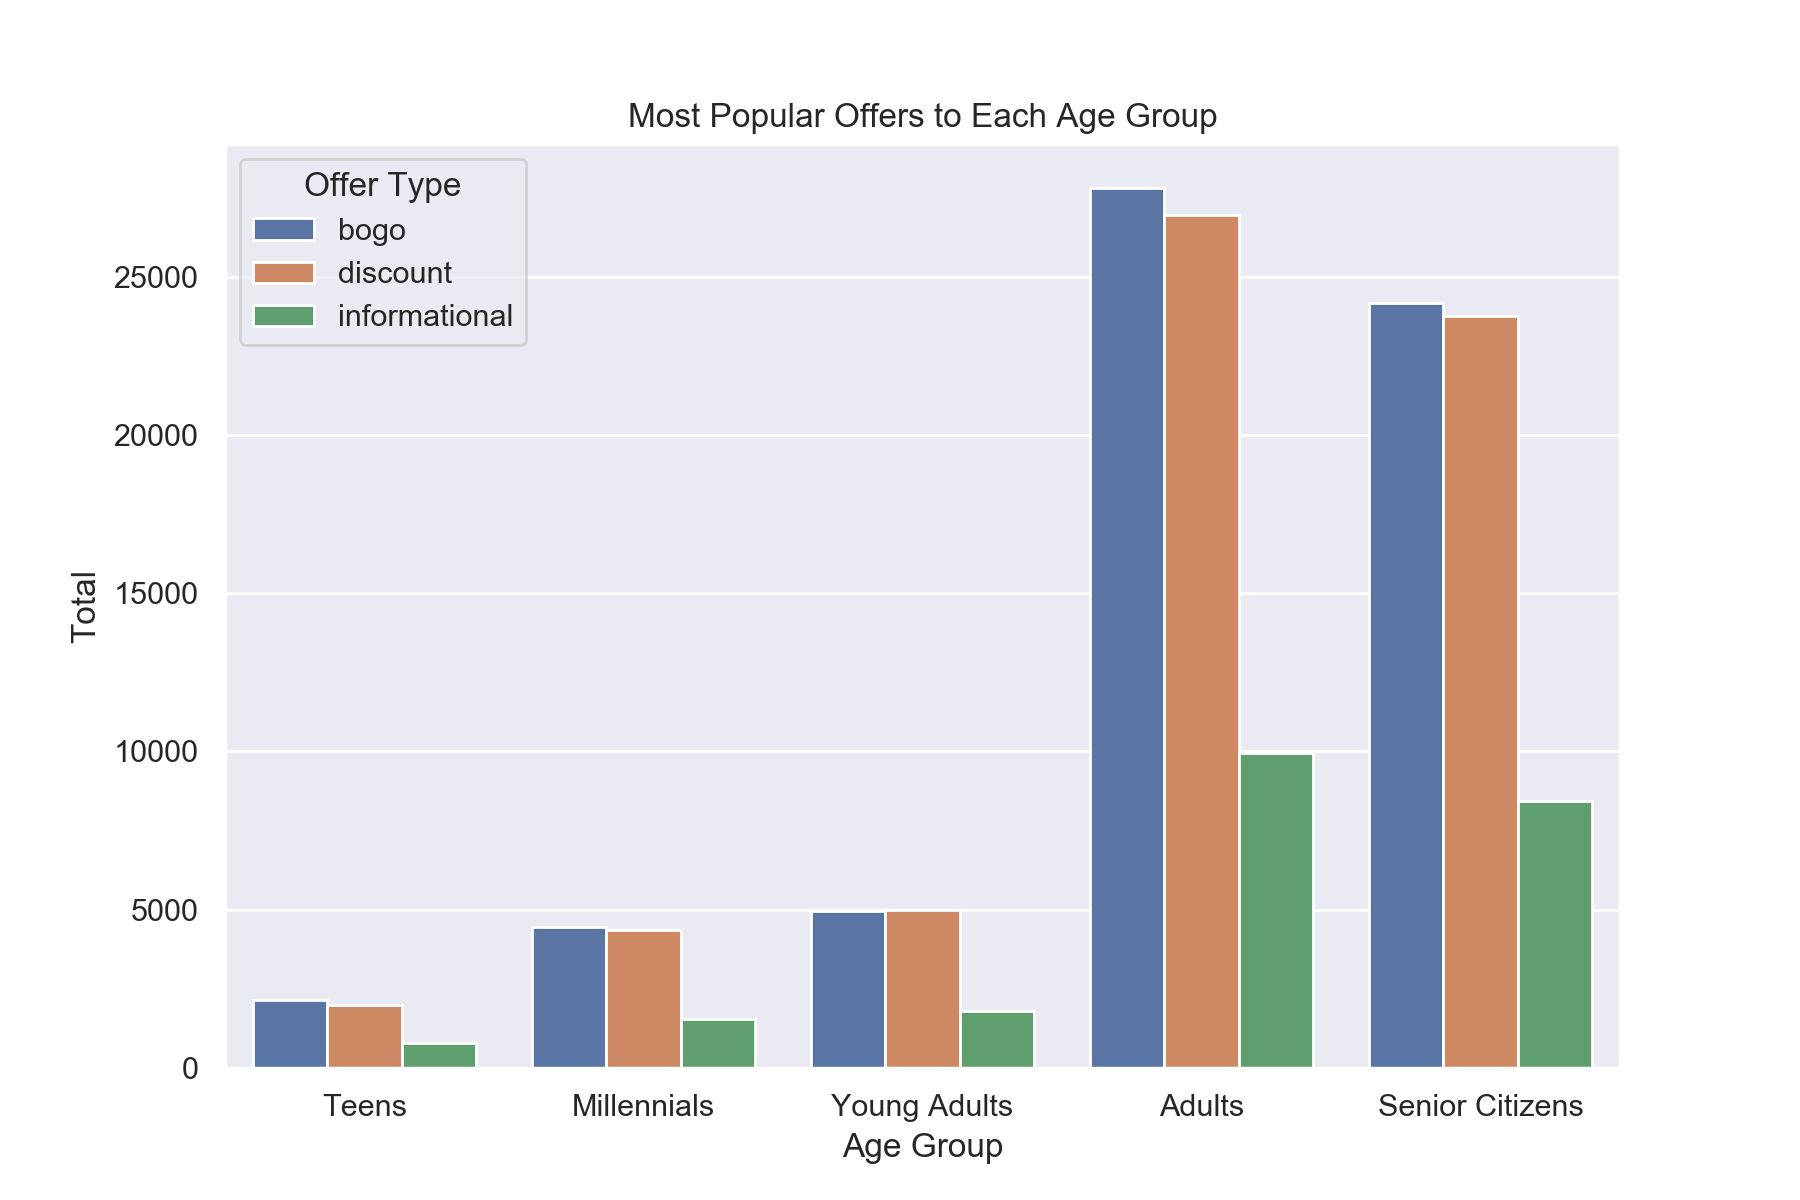

In [35]:
#Q1. What are the most popular offers in the various age groups?
plt.figure(figsize = [9,6])
sns.countplot(x="age_group", hue="offer_type", data=master_df)
plt.title('Most Popular Offers to Each Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')
plt.legend(title='Offer Type')
plt.show();

We can infer from the above plot that in all the age groups the BOGO offer & the discount offer is the most popular whereas the people dont prefer the infomational offer.

<IPython.core.display.Javascript object>


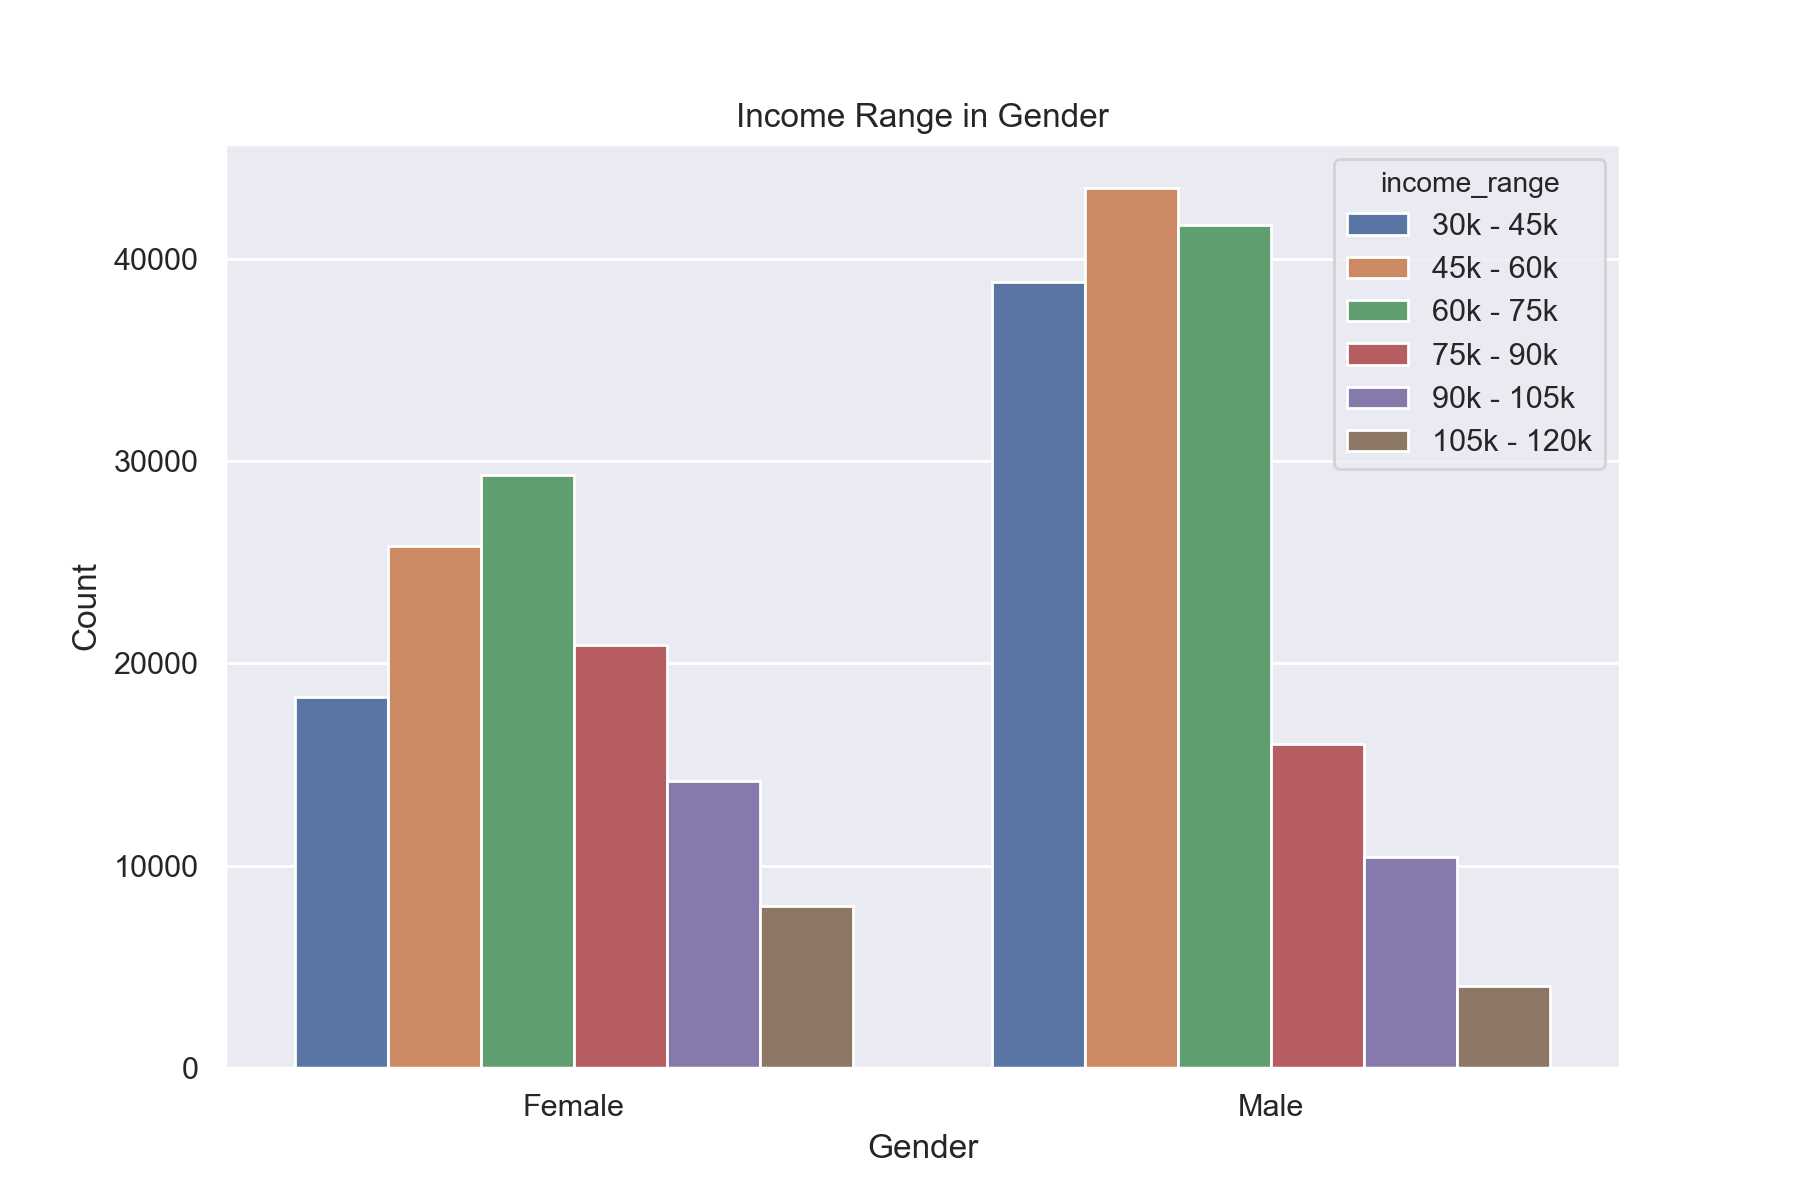

In [36]:
#Q2. How the income range varies for each gender?
plt.figure(figsize = [9,6])
g = sns.countplot(x="gender", hue="income_range", data= master_df)
plt.title('Income Range in Gender')
plt.ylabel('Count')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

In the lower spectrum(less than 75k) we can see that males earn more than females but in the higher spectrum(75k onwards) females earn more.

<IPython.core.display.Javascript object>


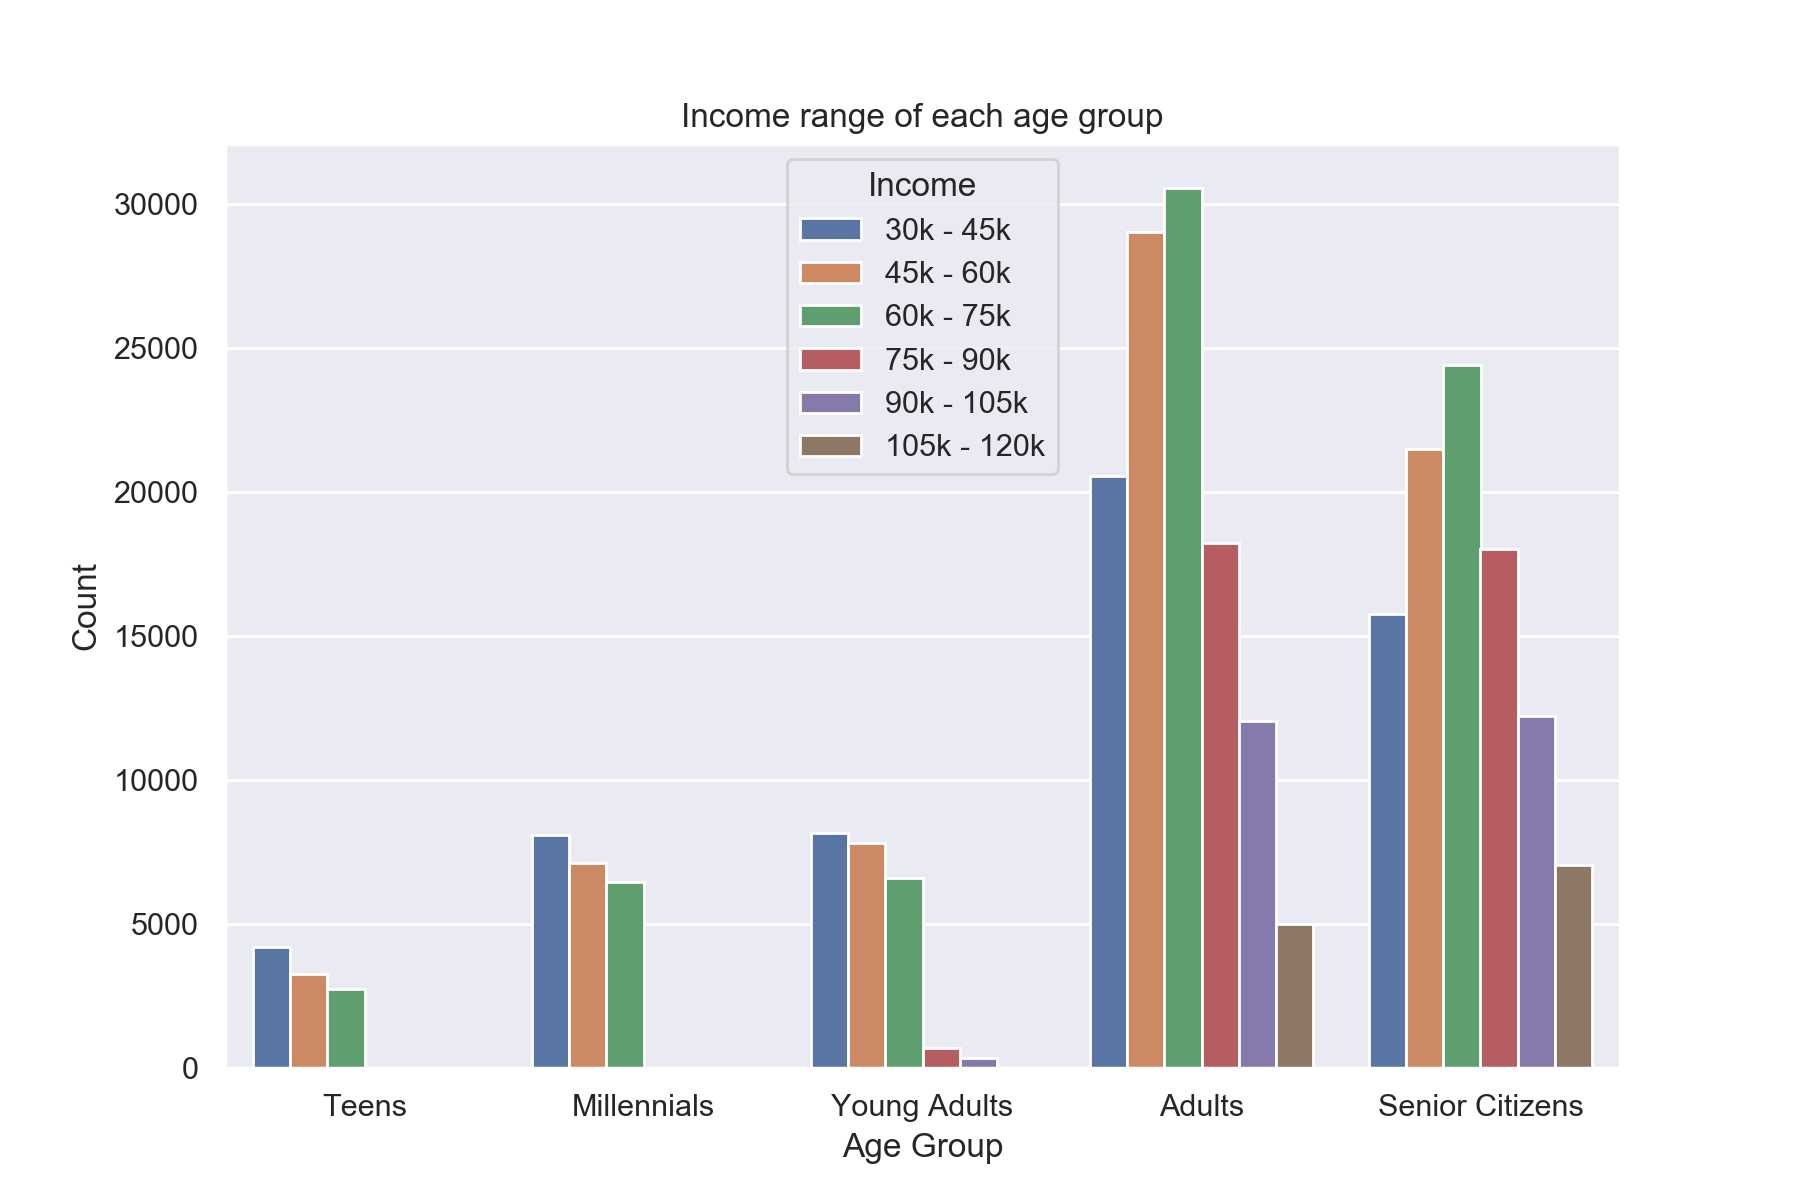

In [37]:
#Q3. How the income range varies for each age group?
plt.figure(figsize = [9,6])
sns.countplot(x="age_group", hue="income_range", data=master_df)
plt.title('Income range of each age group')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Income')
plt.show();

We can see that as there are more adults they are most high earners too. Very few Millennials or young adults earn above 75k. This could be also that the majority of the customers are belonging to the adult category.

<IPython.core.display.Javascript object>


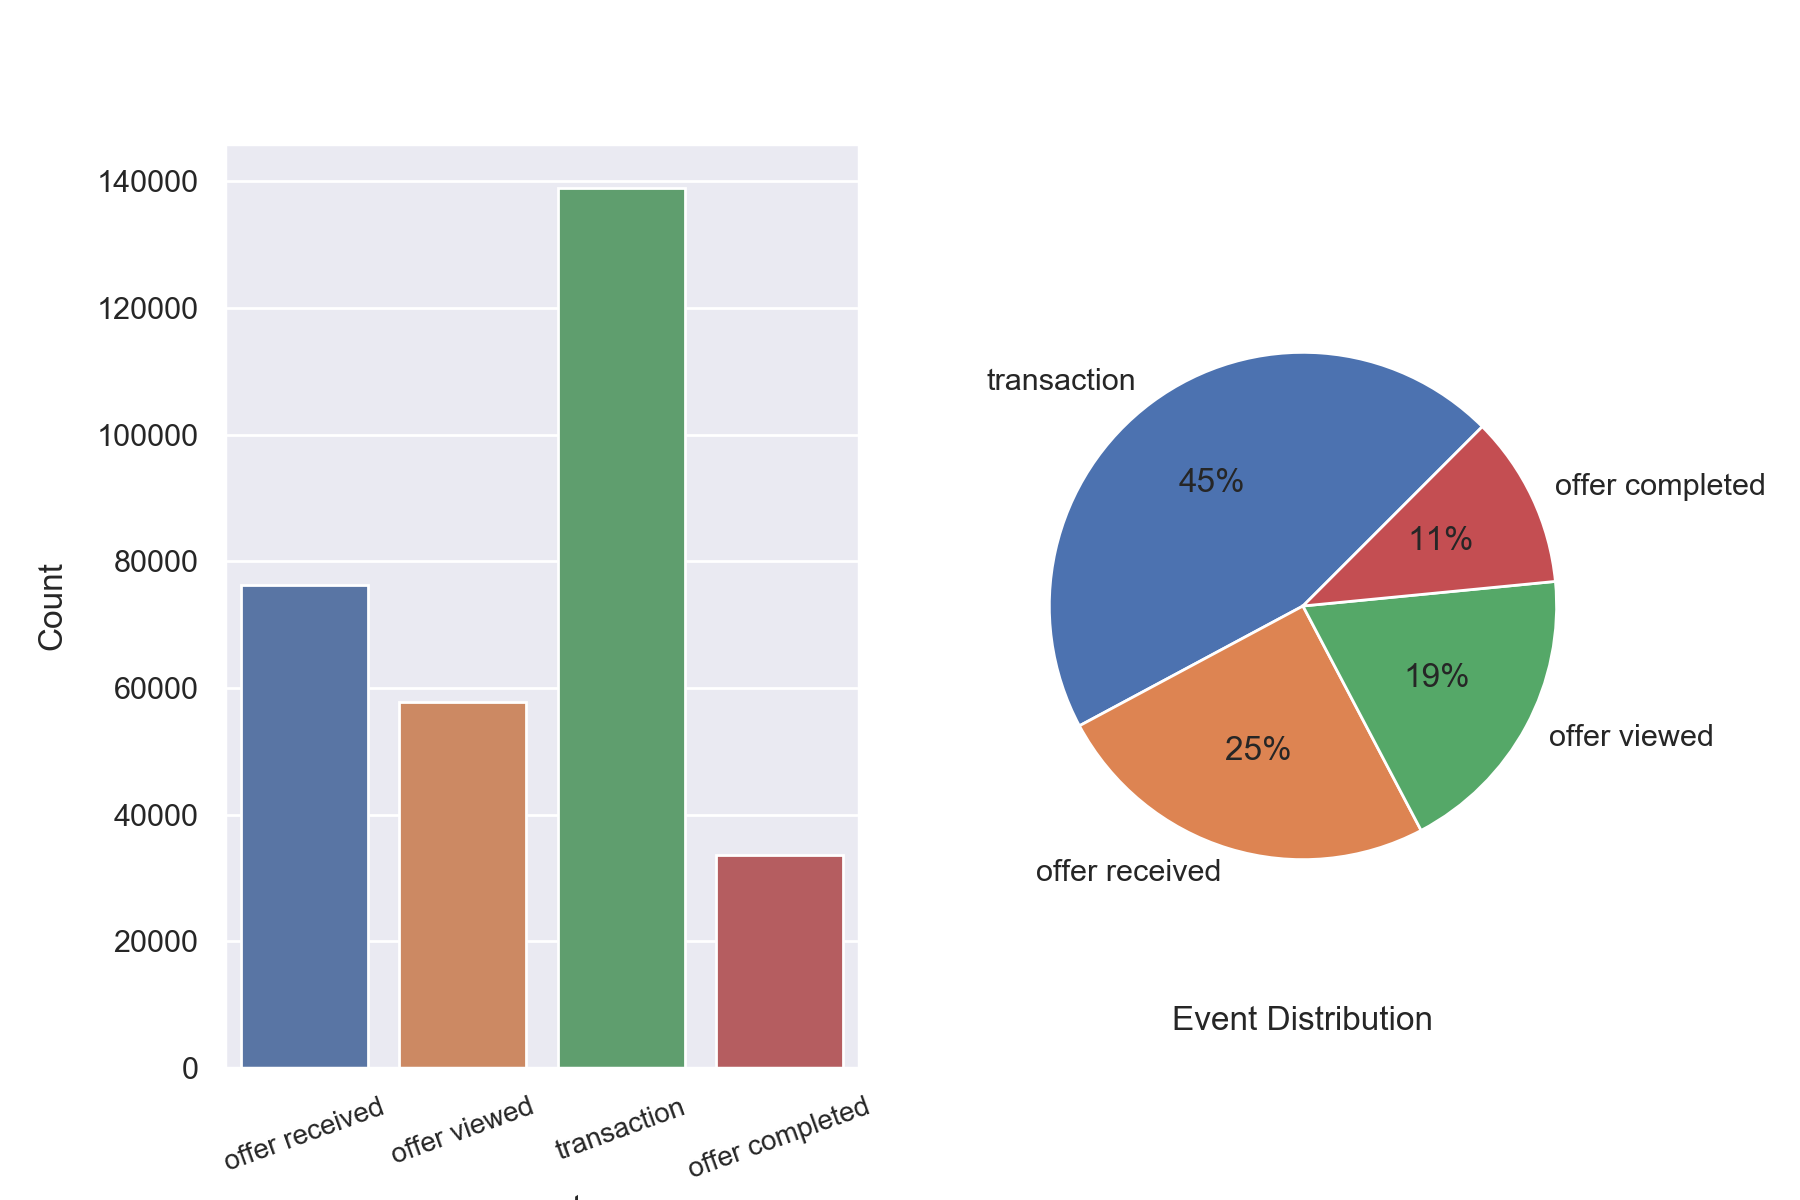

In [38]:
#Q4. How is the data is divided between different events?
plt.figure(figsize = [9,6])
# Barplot
plt.subplot(1,2,1)
sns.countplot(x="event", data=master_df)
plt.xticks(ticks=[0,1,2,3],rotation = 20,fontsize=10);
plt.ylabel('Count',labelpad=10,rotation = 90)
plt.yticks();
#Pieplot
plt.subplot(1,2,2)
master_df['event'].value_counts().plot(kind='pie',startangle = 45,counterclock=True,autopct='%1.0f%%')
plt.ylabel('')
plt.xlabel('Event Distribution',labelpad=30);

We can see that the dataset has two types of events: 

Offer-which is further divided into three classes 

    Offers received 
    Offers viewed 
    Offers completed 
Transaction-which holds records where a transaction has occurred 

Offers make up 55 per cent of the dataset, leaving 45 per cent for transactions. As expected, it was not viewed by all users who received the offer and not by all users who viewed the offer. 


<IPython.core.display.Javascript object>


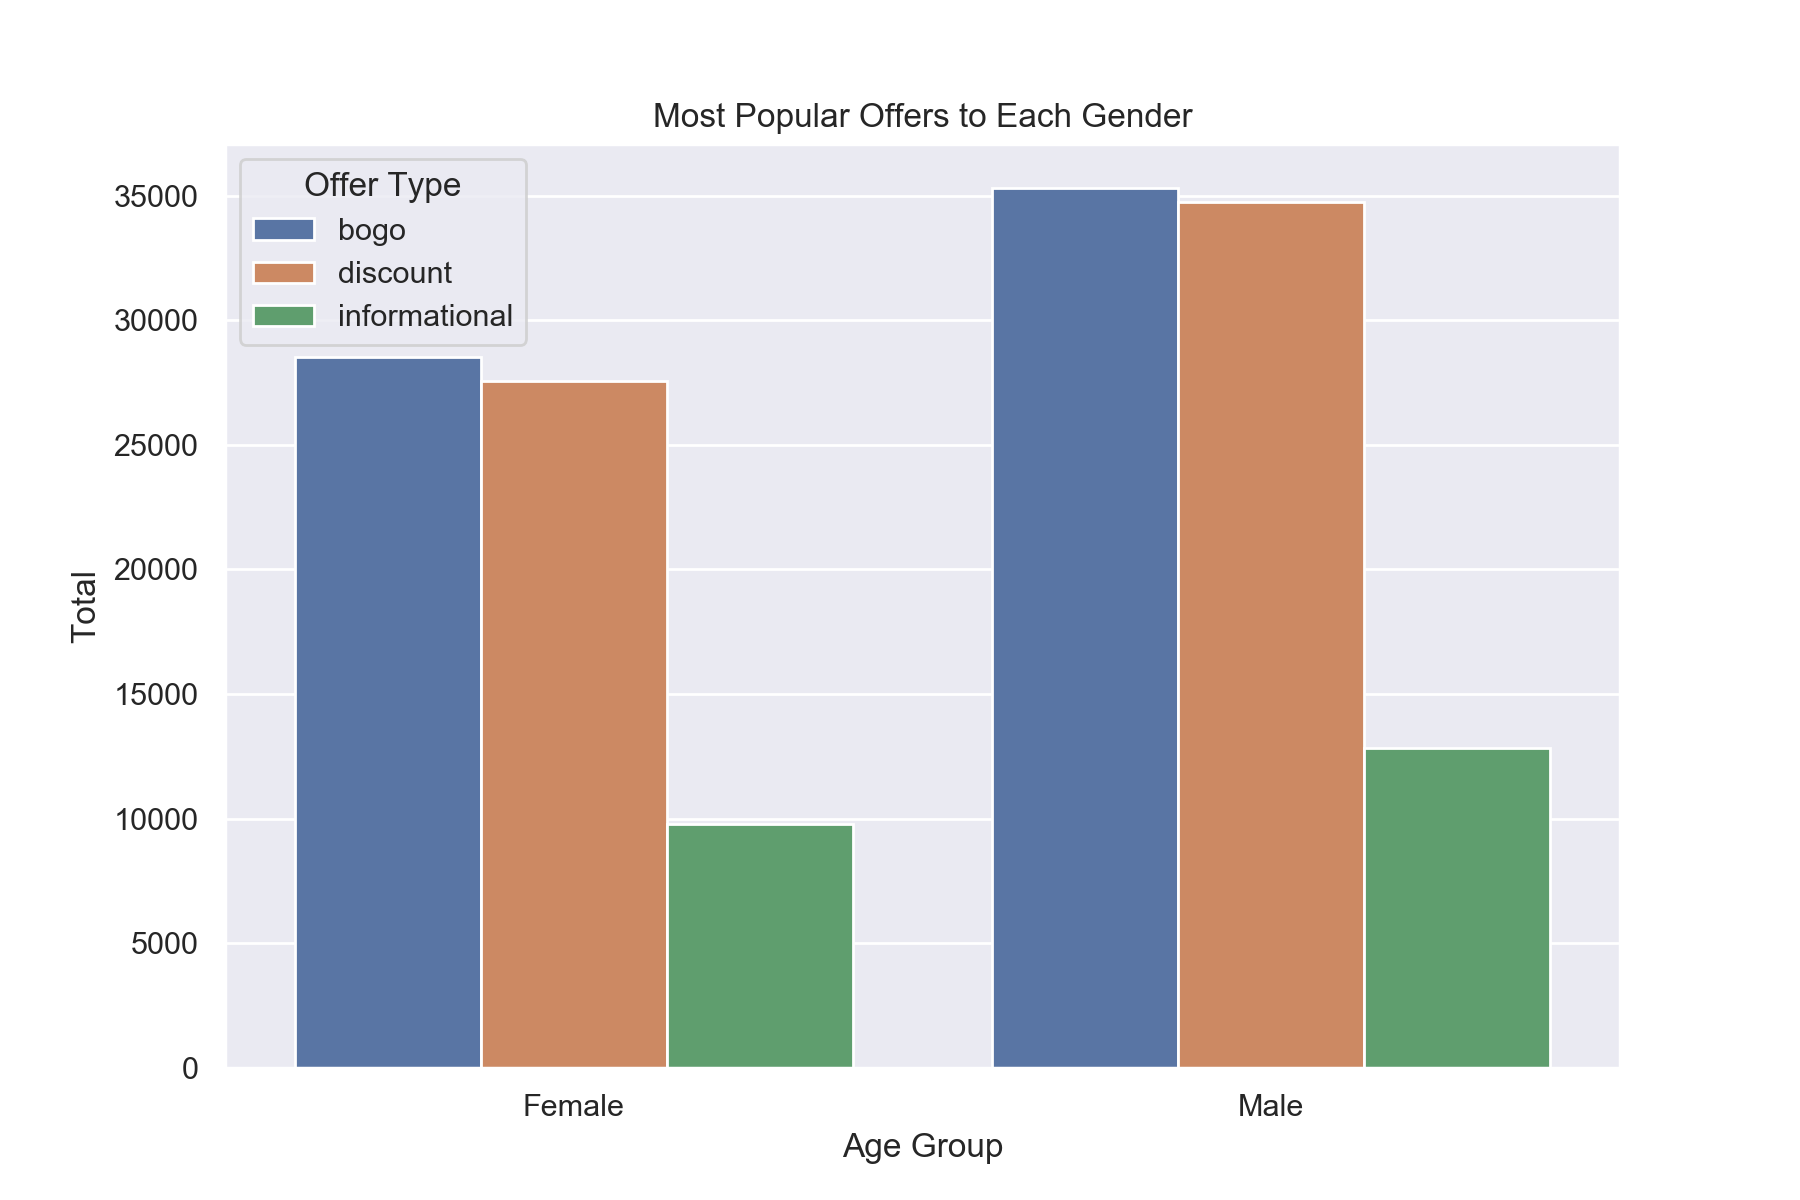

In [39]:
#Q5. What are the most popular offers for each gender?
plt.figure(figsize = [9,6])
g = sns.countplot(x="gender", hue="offer_type", data=master_df)
plt.title('Most Popular Offers to Each Gender')
plt.ylabel('Total')
plt.xlabel('Age Group')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();

The chart we got showed that both genders like BOGO and Discount offers and they have the same reaction toward Informational offers, they both seem to be not intersted to it.

<IPython.core.display.Javascript object>


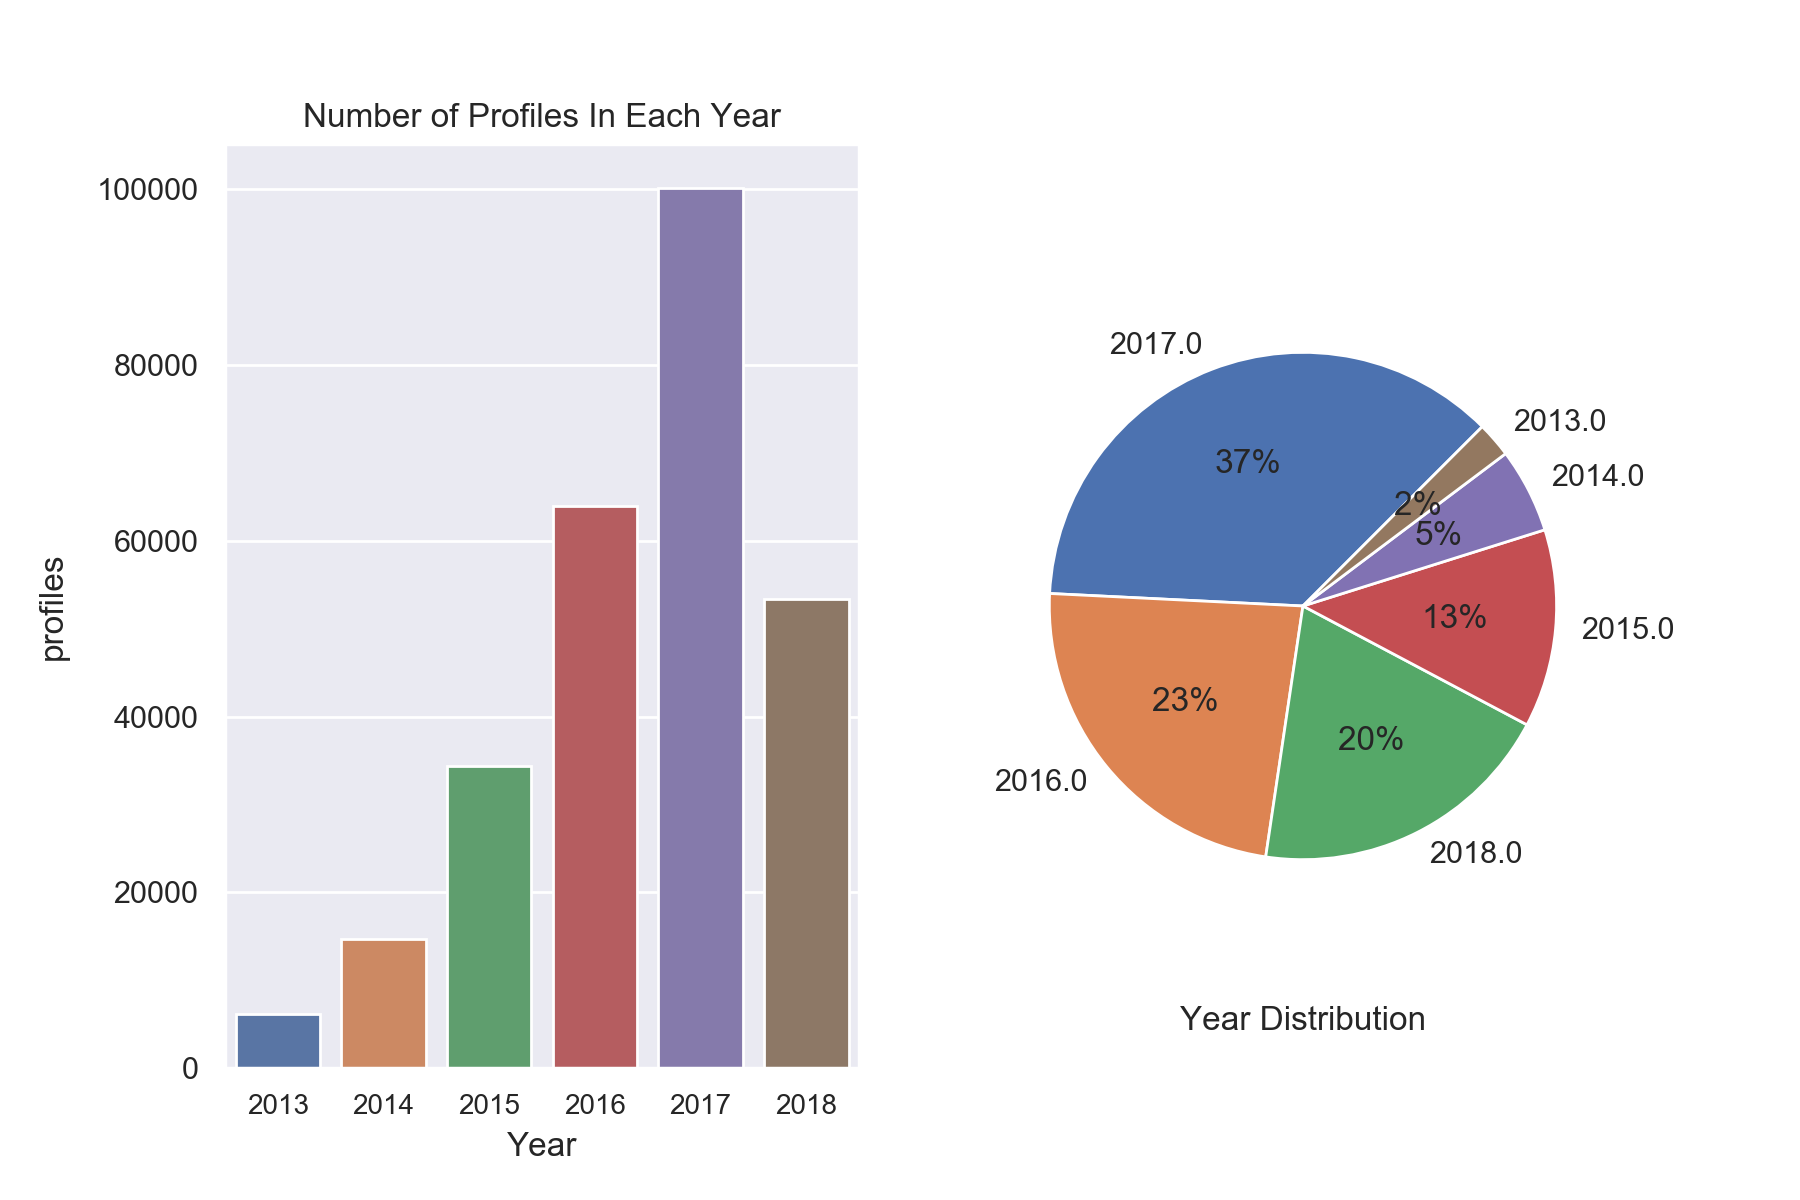

In [65]:
#Q6. How many profiles are added each year?
plt.figure(figsize = [9,6])
# Barplot
plt.subplot(1,2,1)
h = sns.countplot(x="membership_year", data= master_df)
plt.xticks(ticks=[0,1,2,3,4,5],fontsize=10);
xlabels = ['2013','2014','2015','2016','2017','2018']
h.set_xticklabels(xlabels)
plt.xlabel("Year")
plt.ylabel('profiles',labelpad=10,rotation = 90)
plt.title('Number of Profiles In Each Year')
plt.yticks();
#Pieplot
plt.subplot(1,2,2)
g = master_df['membership_year'].value_counts().plot(kind='pie',startangle = 45,counterclock=True,autopct='%1.00f%%')
xlabels = ['2013','2014','2015','2016','2017','2018']
g.set_xticklabels(xlabels)
plt.ylabel('')
plt.xlabel('Year Distribution',labelpad=30);

We can see that the number of profiles increase every year till 2017 whereas they start to fall back again in 2018.

## Top 25 Loyal Customers

In [41]:
loyal_customers = master_df[(master_df['offer completed'] == 1) | (master_df['transaction'] == 1)].groupby(['customer_id', 'offer completed','transaction'])['amount_dollars'].sum().reset_index()
loyal_customers = loyal_customers.sort_values('amount_dollars', ascending=False).head(25)

In [42]:
loyal_customers.head(25)

,customer_id,offer completed,transaction,amount_dollars
6955,3c8d541112a74af99e88abbd0692f00e,0,1,1608.69
27772,f1d65ae63f174b8f80fa063adcaa63b7,0,1,1365.66
20206,ae6f43089b674728a50b8727252d3305,0,1,1327.74
11264,626df8678e2a4953b9098246418c9cfa,0,1,1321.42
13251,73afdeca19e349b98f09e928644610f8,0,1,1319.97
9485,52959f19113e4241a8cb3bef486c6412,0,1,1292.86
20047,ad1f0a409ae642bc9a43f31f56c130fc,0,1,1258.19
24172,d240308de0ee4cf8bb6072816268582b,0,1,1251.99
17093,946fc0d3ecc4492aa4cc06cf6b1492c3,0,1,1232.40
11481,6406abad8e2c4b8584e4f68003de148d,0,1,1211.76


# 4. Data Modelling

## 4.1 Modelling
Making sure our data is ready and optimized for the fitting that will happen later.

In [43]:
master_df.head()

,customer_id,event,time_hour,offer received,offer viewed,transaction,offer completed,amount_dollars,offer_id,reward_given,...,social,gender,age,became_member_on,income,age_group,income_range,membership_year,membership_month,membership_day
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,1,0,0,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,...,0.0,0.0,75.0,2017-05-09,100000.0,Senior Citizens,90k - 105k,2017.0,5.0,9.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,1,0,0,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,...,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,1,0,0,0,0.0,2906b810c7d4411798c6938adc9daaa5,0,...,0.0,1.0,68.0,2018-04-26,70000.0,Senior Citizens,60k - 75k,2018.0,4.0,26.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,1,0,0,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,0,...,1.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,1,0,0,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,...,1.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
#Making the model_df for modelling purpose. Keeping only the necesarry columns and removing the rest.
model_df = master_df.copy()
model_df = model_df.drop(['offer received', 'offer viewed','transaction', 'offer completed','bogo', 'informational', 'discount', 'email', 'web', 'mobile', 'social','age','income_range','became_member_on', 'membership_month','membership_day','reward_given','customer_id'],axis=1)
model_df.head()

,event,time_hour,amount_dollars,offer_id,reward,difficulty,duration,offer_type,gender,income,age_group,membership_year
0,offer received,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,168.0,bogo,0.0,100000.0,Senior Citizens,2017.0
1,offer received,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,240.0,discount,NaN,NaN,NaN,NaN
2,offer received,0,0.0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,168.0,discount,1.0,70000.0,Senior Citizens,2018.0
3,offer received,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,240.0,discount,NaN,NaN,NaN,NaN
4,offer received,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,120.0,bogo,NaN,NaN,NaN,NaN


In [45]:
model_df.describe()

,time_hour,amount_dollars,reward,difficulty,duration,gender,income,membership_year
count,306534.000000,306534.000000,167581.00000,167581.000000,167581.000000,272762.000000,272762.000000,272762.000000
mean,366.382940,5.792023,4.41991,7.850401,158.657700,0.570791,64337.000755,2016.457435
std,200.326314,21.337137,3.37336,5.048944,51.267123,0.494964,21243.762941,1.218663
min,0.000000,0.000000,0.00000,0.000000,72.000000,0.000000,30000.000000,2013.000000
25%,186.000000,0.000000,2.00000,5.000000,120.000000,0.000000,48000.000000,2016.000000
50%,408.000000,0.000000,5.00000,10.000000,168.000000,1.000000,62000.000000,2017.000000
75%,528.000000,7.100000,5.00000,10.000000,168.000000,1.000000,78000.000000,2017.000000
max,714.000000,1062.280000,10.00000,20.000000,240.000000,1.000000,120000.000000,2018.000000


In [46]:
#Engineering the features into number so that it becomes easy to analyse. I have taken inspiration for a post on stackoverflow.
labels_event = model_df['event'].astype('category').cat.categories.tolist()
replace_map_comp_event = {'event' : {k: v for k,v in zip(labels_event,list(range(1,len(labels_event)+1)))}}
model_df.replace(replace_map_comp_event, inplace=True)
print(replace_map_comp_event)

labels_offer_id = model_df['offer_id'].astype('category').cat.categories.tolist()
replace_map_comp_offer_id = {'offer_id' : {k: v for k,v in zip(labels_offer_id,list(range(1,len(labels_offer_id)+1)))}}
model_df.replace(replace_map_comp_offer_id, inplace=True)
print(replace_map_comp_offer_id)

labels_age_group = model_df['age_group'].astype('category').cat.categories.tolist()
replace_map_comp_age_group = {'age_group' : {k: v for k,v in zip(labels_age_group,list(range(1,len(labels_age_group)+1)))}}
model_df.replace(replace_map_comp_age_group, inplace=True)
print(replace_map_comp_age_group)

labels_gender = model_df['gender'].astype('category').cat.categories.tolist()
replace_map_comp_gender = {'gender' : {k: v for k,v in zip(labels_gender,list(range(1,len(labels_gender)+1)))}}
model_df.replace(replace_map_comp_gender, inplace=True)
print(replace_map_comp_gender)

labels_difficulty = model_df['difficulty'].astype('category').cat.categories.tolist()
replace_map_comp_difficulty = {'difficulty' : {k: v for k,v in zip(labels_difficulty,list(range(1,len(labels_difficulty)+1)))}}
model_df.replace(replace_map_comp_difficulty, inplace=True)
print(replace_map_comp_difficulty)

labels_offer_type = model_df['offer_type'].astype('category').cat.categories.tolist()
replace_map_comp_offer_type = {'offer_type' : {k: v for k,v in zip(labels_offer_type,list(range(1,len(labels_offer_type)+1)))}}
model_df.replace(replace_map_comp_offer_type, inplace=True)
print(replace_map_comp_offer_type)
model_df.head()

{'event': {'offer completed': 1, 'offer received': 2, 'offer viewed': 3, 'transaction': 4}}
{'offer_id': {'0b1e1539f2cc45b7b9fa7c272da2e1d7': 1, '2298d6c36e964ae4a3e7e9706d1fb8c2': 2, '2906b810c7d4411798c6938adc9daaa5': 3, '3f207df678b143eea3cee63160fa8bed': 4, '4d5c57ea9a6940dd891ad53e9dbe8da0': 5, '5a8bc65990b245e5a138643cd4eb9837': 6, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 7, 'ae264e3637204a6fb9bb56bc8210ddfd': 8, 'f19421c1d4aa40978ebb69ca19b0e20d': 9, 'fafdcd668e3743c1bb461111dcafc2a4': 10}}
{'age_group': {'Teens': 1, 'Millennials': 2, 'Young Adults': 3, 'Adults': 4, 'Senior Citizens': 5}}
{'gender': {0.0: 1, 1.0: 2}}
{'difficulty': {0.0: 1, 5.0: 2, 7.0: 3, 10.0: 4, 20.0: 5}}
{'offer_type': {'bogo': 1, 'discount': 2, 'informational': 3}}


,event,time_hour,amount_dollars,offer_id,reward,difficulty,duration,offer_type,gender,income,age_group,membership_year
0,2,0,0.0,7.0,5.0,2.0,168.0,1.0,1.0,100000.0,5.0,2017.0
1,2,0,0.0,1.0,5.0,5.0,240.0,2.0,NaN,NaN,NaN,NaN
2,2,0,0.0,3.0,2.0,4.0,168.0,2.0,2.0,70000.0,5.0,2018.0
3,2,0,0.0,10.0,2.0,4.0,240.0,2.0,NaN,NaN,NaN,NaN
4,2,0,0.0,5.0,10.0,4.0,120.0,1.0,NaN,NaN,NaN,NaN


In [47]:
#performing few updates on the model_df to make the analysis smoother
model_df.reset_index(inplace = True)
model_df.drop(['index'], axis=1,inplace = True) 
model_df = model_df.replace(np.nan, 0 ,regex=True)
list_columns = list(['event', 'time_hour', 'offer_id', 'reward',
       'difficulty', 'duration', 'offer_type', 'gender', 'income', 'age_group',
       'membership_year'])
for values in list_columns:
    model_df[values] = model_df[values].astype(int)
model_df.head()

,event,time_hour,amount_dollars,offer_id,reward,difficulty,duration,offer_type,gender,income,age_group,membership_year
0,2,0,0.0,7,5,2,168,1,1,100000,5,2017
1,2,0,0.0,1,5,5,240,2,0,0,0,0
2,2,0,0.0,3,2,4,168,2,2,70000,5,2018
3,2,0,0.0,10,2,4,240,2,0,0,0,0
4,2,0,0.0,5,10,4,120,1,0,0,0,0


In [48]:
#Split the data into X(features) and Y(target) label
X = model_df.drop(['event'], axis = 1)
Y = model_df['event']

In [49]:
Y.tail()

306529    4
306530    4
306531    4
306532    4
306533    4
Name: event, dtype: int64

In [50]:
X.head()

,time_hour,amount_dollars,offer_id,reward,difficulty,duration,offer_type,gender,income,age_group,membership_year
0,0,0.0,7,5,2,168,1,1,100000,5,2017
1,0,0.0,1,5,5,240,2,0,0,0,0
2,0,0.0,3,2,4,168,2,2,70000,5,2018
3,0,0.0,10,2,4,240,2,0,0,0,0
4,0,0.0,5,10,4,120,1,0,0,0,0


In [51]:
#normalizing the data
scaler = MinMaxScaler()
normalize = ['time_hour', 'amount_dollars', 'reward', 'income','duration']
X[normalize] = scaler.fit_transform(X[normalize])
X.head()

,time_hour,amount_dollars,offer_id,reward,difficulty,duration,offer_type,gender,income,age_group,membership_year
0,0.0,0.0,7,0.5,2,0.7,1,1,0.833333,5,2017
1,0.0,0.0,1,0.5,5,1.0,2,0,0.000000,0,0
2,0.0,0.0,3,0.2,4,0.7,2,2,0.583333,5,2018
3,0.0,0.0,10,0.2,4,1.0,2,0,0.000000,0,0
4,0.0,0.0,5,1.0,4,0.5,1,0,0.000000,0,0


In [52]:
#Dividing the data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.25, random_state=42)

In [53]:
print('Training X Shape:', X_train.shape)
print('Training Y Shape:', Y_train.shape)
print('Testing X Shape:', X_test.shape)
print('Testing Y Shape:', Y_test.shape)

Training X Shape: (229900, 11)
Training Y Shape: (229900,)
Testing X Shape: (76634, 11)
Testing Y Shape: (76634,)


In [54]:
# defining a function to calculate the accuracy for the models we will try below. Inspired by Stackoverflow
def predict_score(model):
    pred = model.predict(X_test)
    
    # Calculate the absolute errors
    errors = abs(pred - Y_test)
    
    # Calculate mean absolute percentage error
    mean_APE = 100 * (errors / Y_test)
    accuracy = 100 - np.mean(mean_APE)
    
    return round(accuracy, 2)

In [55]:
# 1. Logistic Regression
logreg = LogisticRegression(solver='liblinear',multi_class = 'ovr')
logreg.fit(X_train, Y_train)
print(f'Accuracy of Logistic regression classifier on training set: {round(logreg.score(X_train, Y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(logreg)}%')

Accuracy of Logistic regression classifier on training set: 70.49%.
Prediction Accuracy: 81.74%


In [56]:
# 2. Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, Y_train)
print(f'Accuracy of Linear regression classifier on training set: {round(linreg.score(X_train, Y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(linreg)}%')

Accuracy of Linear regression classifier on training set: 73.85%.
Prediction Accuracy: 78.88%


In [57]:
# 3. Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, Y_train)
print(f'Accuracy of Decision Tree classifier on training set: {round(dt.score(X_train, Y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(dt)}%')

Accuracy of Decision Tree classifier on training set: 94.79%.
Prediction Accuracy: 82.9%


In [58]:
# 4. Naive Bayes
gnb = GaussianNB() 
gnb.fit(X_train, Y_train) 
print(f'Accuracy of Naive Bayes classifier on training set: {round(gnb.score(X_train, Y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(gnb)}%')

Accuracy of Naive Bayes classifier on training set: 64.82%.
Prediction Accuracy: 80.18%


In [59]:
# 5. KNN Classifier
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
print(f'Accuracy of K-NN classifier on training set: {round(knn.score(X_train, Y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(knn)}%')

Accuracy of K-NN classifier on training set: 82.37%.
Prediction Accuracy: 81.39%


In [60]:
# 6.  Random Forest
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(X_train, Y_train)
print(f'Accuracy of SVM classifier on training set: {round(rf.score(X_train, Y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(rf)}%')

Accuracy of SVM classifier on training set: 93.32%.
Prediction Accuracy: 82.41%


## 4.2 Modelling Results

In [61]:
#creating the variables that will be used to fill the results table
models = [logreg,linreg, knn, dt, rf, gnb]
model_names = [type(n).__name__ for n in models]
train_accuracy = [x.score(X_train, Y_train)*100 for x in models]
predict_accuracy = [predict_score(y) for y in models]
#structuring a table to view the results of the different model tried above
results = [train_accuracy, predict_accuracy]
results_df = pd.DataFrame(results, columns = model_names, index=['Training Accuracy', 'Predicting Accuracy']) 
results_df.head()

,LogisticRegression,LinearRegression,KNeighborsClassifier,DecisionTreeClassifier,RandomForestRegressor,GaussianNB
Training Accuracy,70.494998,73.854614,82.369291,94.790779,93.318469,64.817747
Predicting Accuracy,81.740000,78.880000,81.390000,82.900000,82.410000,80.180000


From the above table and analysis we come to conclusion that the best method is the decision tree classifier. Is provides the maximum training accuracy and the best prediciting accuracy. We will go ahead and perform improvements on this model. It is good here because we have good amount of data to work with.

## 4.3 Model Improvements

In [62]:
dt.get_params() #checking the various parameters of decision tree

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 42,
 'splitter': 'best'}

In [63]:
#using gridsearchCV to find the best parameters
params = {'max_leaf_nodes': list(range(80, 100)), 
          'min_samples_split': [2, 3]}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
gs.fit(X_train, Y_train)
print(f'Best Score: {gs.best_score_*100}%.')
print(f'Best parameters: {gs.best_params_}')

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   47.4s finished


Best Score: 87.14267072640278%.
Best parameters: {'max_leaf_nodes': 89, 'min_samples_split': 2}


In [64]:
#transfering the best model into gs_best and finding the values
gs_best = gs.best_estimator_
print(f'Accuracy of the best estimators of decision tree on training set: {round(gs_best.score(X_train, Y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(gs_best)}%')

Accuracy of the best estimators of decision tree on training set: 87.32%.
Prediction Accuracy: 86.78%


From the original fitting to using the best parameters for fitting we gain almost 4 percent in accuracy which is very good. Even though the accuracy on the training model goes down.

# 5. Conclusion

Throughout this project i have analysed the dataset given by starbucks and i have tried to predict what happens when a customer is presented with an offer.Whether the person just views it or completes it or performs a transaction. The dataset given was very huge and extensive.
First, I've examined every dataset, evaluated its different aspects in order to gain an overall understanding of the data. Then I switched to the pre-processing portion. Pre-processing Data was the job that took much of the time and energy. The dataset is a little complicated and the data included allowed me to use my wrangling / engineering and pre-processing expertise to get the final clean version of the three datasets.

According to me the preprocessing and making the data ready for analysis was the hardest part because there were three sets to be analysed. I loved doing the explotory data analysis and plotting all the charts.

**Quick Facts and Interesting analysis**
1. Income of everyone is between 30k and 120k where men earn more in the lower spectrum (less than 75k) and women earn more in the higher spectrum.
2. There are 17k customers in the database with almost 2175 with no age,gender or income. These are the people who dont want to give their personal details.
3. The most common offer type among all age groups is the BOGO , followed by the Discount Offers. Whereas, the least common offer to be sent is the informational offers. I believe that BOGO offers are more attractive compared to other offers provided by Starbucks.

Finally i would conclude that i have successfully made a model which tells with 87% accuracy that what happens when a customer is presented with an offer.
I really enjoyed doing the whole project. Though it was very extensive it was fun and engaging. 

# 6. Improvements
I believe that there is always scope for improvement. Here we can use deep learning for a much better fitting. Or we could look at a few more features. We could also collect features like the demographics, branch, time of day etc.